# Mixed layer depth changes

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cosima_cookbook as cc
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import scipy.stats as st
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:39305 Dashboard: /proxy/41167/status,Cluster Workers: 6 Cores: 24 Memory: 155.69 GB


In [61]:
# Font size
plt.rcParams['font.size'] = 16
# Axes
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# Saving parameters
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

def figure_along_slope():
    
    fig, axs = plt.subplots(figsize = (15, 5))
    axs.set_ylim(-80, -60);
    axs.set_xticks(np.arange(-250, 100, 50))
    axs.set_yticks(np.arange(-80, -55, 5))
    axs.set_xlabel('Longitude')
    axs.set_ylabel('Latitude')
    
    return fig, axs

def southern_ocean(ds):
    ds = ds.sel(yt_ocean = slice(None, -50))
    return ds

def southern_ocean_plot():
    fig = plt.figure(1, figsize = (16, 12))
    ax1 = fig.add_axes([0.0, 0.5, 0.5, 0.5], projection = ccrs.SouthPolarStereo())
    ax1.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'darkgrey', facecolor = 'darkgrey'))
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform = ax1.transAxes)
    
    ax2 = fig.add_axes([0.42, 0.5, 0.5, 0.5],projection = ccrs.SouthPolarStereo())
    ax2.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'darkgrey', facecolor = 'darkgrey'))
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax2.set_boundary(circle, transform = ax2.transAxes)
    
    ax3 = fig.add_axes([0.1, 0.43, 0.3, 0.02])
    ax4 = fig.add_axes([0.53, 0.43, 0.3, 0.02])
    plt.tight_layout()
    return fig, [ax1, ax2, ax3, ax4]

In [14]:
hu = xr.open_dataset('/scratch/e14/jn8053/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))

In [3]:
files_ryf = [f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output{n}/ocean/ocean_month.nc" for n in np.arange(996, 1056, 1)]
files_easup = [f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_up10/output{n}/ocean/ocean_month.nc" for n in np.arange(996, 1056, 1)]
files_easdo = [f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_down10//output{n}/ocean/ocean_month.nc" for n in np.arange(996, 1056, 1)]

In [4]:
example = xr.open_dataset(files_ryf[0])
drop = [i for i in example.variables]
drop.remove('mld')
drop.remove('xt_ocean')
drop.remove('yt_ocean')
drop.remove('time')

In [7]:
mld_ryf = xr.open_mfdataset(files_ryf, parallel = True, preprocess = southern_ocean, concat_dim = 'time', drop_variables = drop)
mld_up = xr.open_mfdataset(files_easup, parallel = True, preprocess = southern_ocean, concat_dim = 'time', drop_variables = drop)
mld_down = xr.open_mfdataset(files_easdo, parallel = True, preprocess = southern_ocean, concat_dim = 'time', drop_variables = drop)

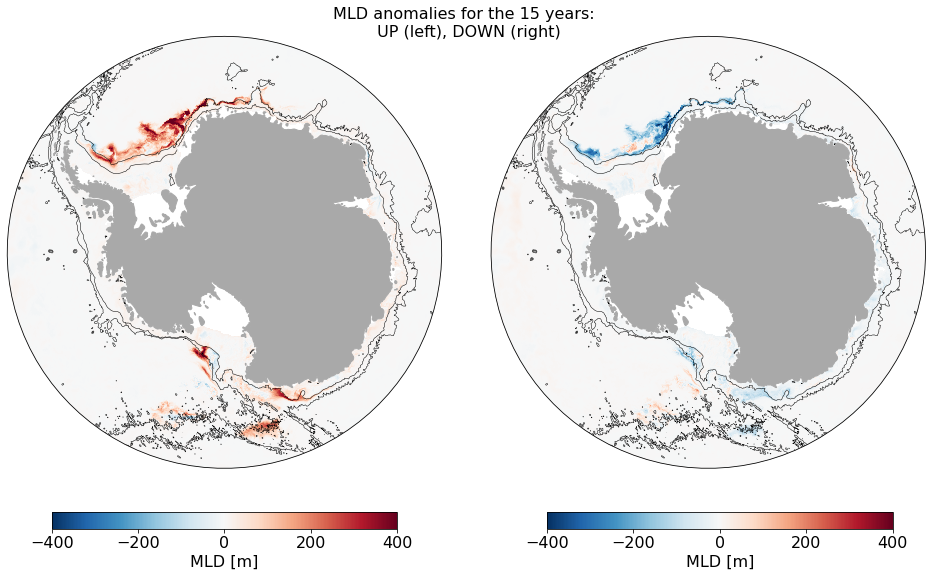

In [17]:
fig, axs = southern_ocean_plot()
fig.text(0.46, 1, 'MLD anomalies for the 15 years: \n UP (left), DOWN (right)', fontsize = 16, ha = 'center')
cf = axs[0].pcolormesh(mld_up['xt_ocean'], mld_up['yt_ocean'], mld_up['mld'].mean('time') - mld_ryf['mld'].mean('time'), 
                       vmin = -400, vmax = 400, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[0].contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
               linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, cax = axs[2], orientation = 'horizontal', shrink = .5)
cbar.set_label('MLD [m]')

cf = axs[1].pcolormesh(mld_up['xt_ocean'], mld_up['yt_ocean'], mld_down['mld'].mean('time') - mld_ryf['mld'].mean('time'), 
                       vmin = -400, vmax = 400, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
axs[1].contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
               linewidths = 0.5, transform = ccrs.PlateCarree())
cbar = fig.colorbar(cf, cax = axs[3], orientation = 'horizontal', shrink = .5)
cbar.set_label('MLD [m]')

plt.tight_layout()
plt.savefig(figdir+'easterlies-collaborative/mld-mean.png')

In [29]:
mask_file = np.load('/g/data/e14/hd4873/runs/parcels/input/proj01/Antarctic_slope_contour_ht_1000m.npz')
shelf_mask = mask_file['contour_masked_above']
xt_ocean = mask_file['xt_ocean']
yt_ocean = mask_file['yt_ocean']
shelf_mask[shelf_mask != 0] = np.nan
shelf_mask[shelf_mask == 0] = 1
shelf_mask = xr.DataArray(shelf_mask, dims = ['yt_ocean', 'xt_ocean'], coords = {'yt_ocean':yt_ocean, 'xt_ocean':xt_ocean})

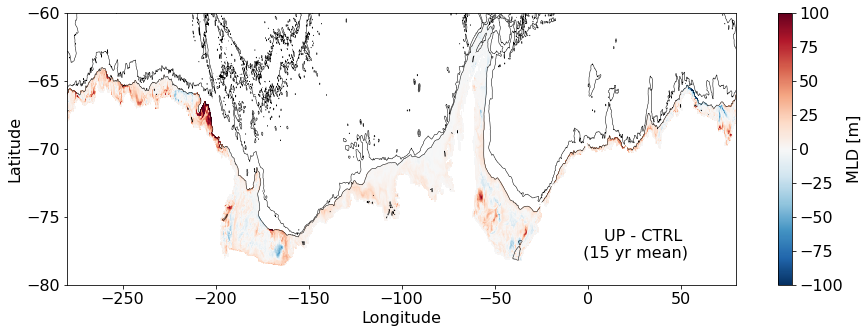

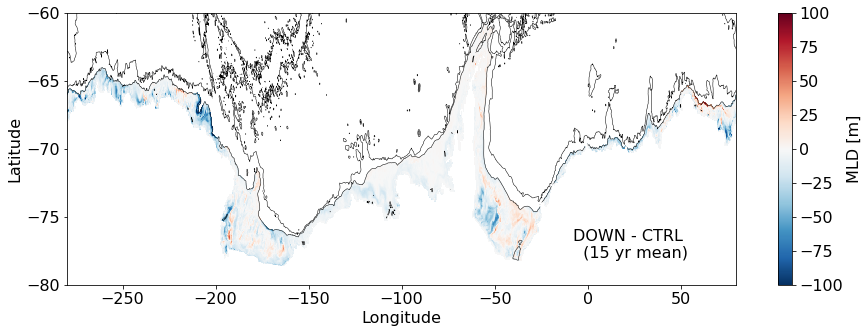

In [79]:
fig, axs = figure_along_slope()
cf = axs.pcolormesh(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], 
                    ((mld_up['mld'].mean('time') - mld_ryf['mld'].mean('time')).sel(yt_ocean = slice(None, -59)))*shelf_mask, 
                    vmin = -100, vmax = 100, cmap = 'RdBu_r')
axs.contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
            linewidths = 0.5)
fig.text(0.7, 0.2, 'UP - CTRL \n (15 yr mean)', fontsize = 16, ha = 'right')
cbar = fig.colorbar(cf, ax = axs, orientation = 'vertical')
cbar.set_label('MLD [m]')
plt.savefig(figdir+'easterlies-collaborative/mld-onshelf-up-mean.png')

fig, axs = figure_along_slope()
cf = axs.pcolormesh(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], 
                    ((mld_down['mld'].mean('time') - mld_ryf['mld'].mean('time')).sel(yt_ocean = slice(None, -59)))*shelf_mask, 
                    vmin = -100, vmax = 100, cmap = 'RdBu_r')
axs.contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
            linewidths = 0.5)
fig.text(0.7, 0.2, 'DOWN - CTRL \n (15 yr mean)', fontsize = 16, ha = 'right')
cbar = fig.colorbar(cf, ax = axs, orientation = 'vertical')
cbar.set_label('MLD [m]')
plt.savefig(figdir+'easterlies-collaborative/mld-onshelf-down-mean.png')

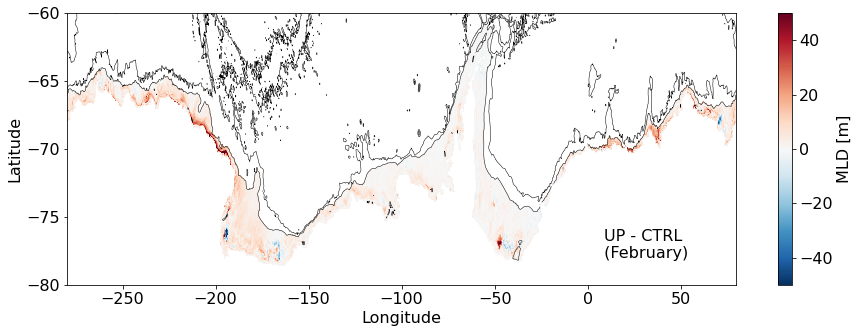

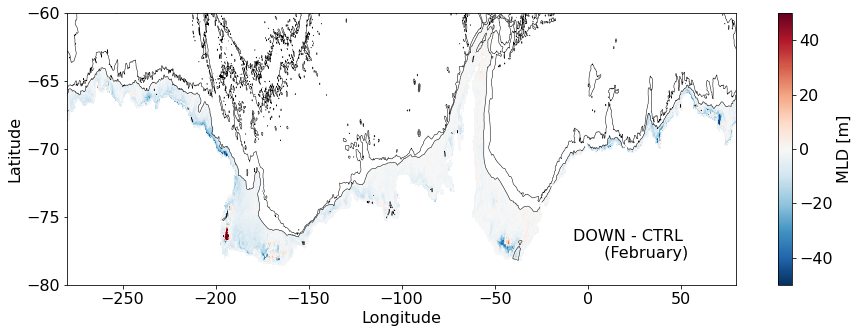

In [80]:
fig, axs = figure_along_slope()
cf = axs.pcolormesh(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], 
                   ((mld_up['mld'].groupby('time.month').mean('time').isel(month = 2) - mld_ryf['mld'].groupby('time.month').mean('time').isel(month = 2)).sel(yt_ocean = slice(None, -59)))*shelf_mask, 
                    vmin = -50, vmax = 50, cmap = 'RdBu_r')
axs.contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
            linewidths = 0.5)
fig.text(0.7, 0.2, 'UP - CTRL \n (February)', fontsize = 16, ha = 'right')
cbar = fig.colorbar(cf, ax = axs, orientation = 'vertical')
cbar.set_label('MLD [m]')
plt.savefig(figdir+'easterlies-collaborative/mld-onshelf-up-summer.png')

fig, axs = figure_along_slope()
cf = axs.pcolormesh(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], 
                   ((mld_down['mld'].groupby('time.month').mean('time').isel(month = 2) - mld_ryf['mld'].groupby('time.month').mean('time').isel(month = 2)).sel(yt_ocean = slice(None, -59)))*shelf_mask, 
                    vmin = -50, vmax = 50, cmap = 'RdBu_r')
axs.contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
            linewidths = 0.5)
fig.text(0.7, 0.2, 'DOWN - CTRL \n (February)', fontsize = 16, ha = 'right')
cbar = fig.colorbar(cf, ax = axs, orientation = 'vertical')
cbar.set_label('MLD [m]')
plt.savefig(figdir+'easterlies-collaborative/mld-onshelf-down-summer.png')

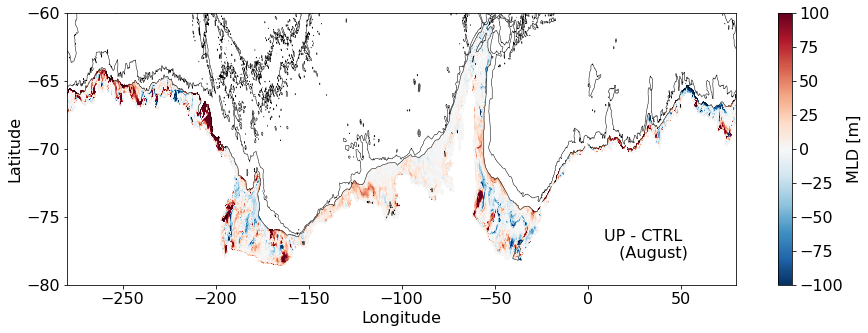

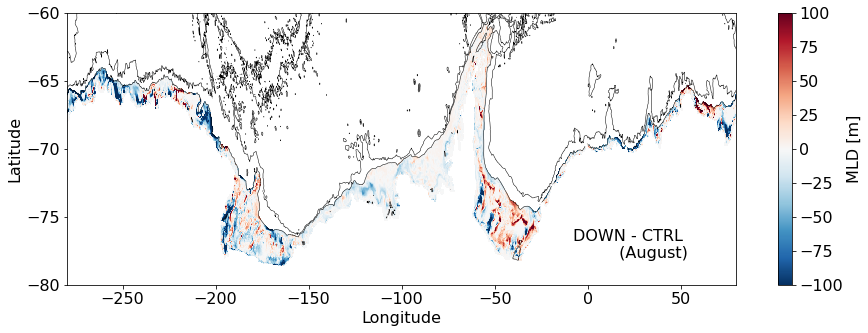

In [81]:
fig, axs = figure_along_slope()
cf = axs.pcolormesh(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], 
                   ((mld_up['mld'].groupby('time.month').mean('time').isel(month = 8) - mld_ryf['mld'].groupby('time.month').mean('time').isel(month = 8)).sel(yt_ocean = slice(None, -59)))*shelf_mask, 
                   vmin = -100, vmax = 100, cmap = 'RdBu_r')
axs.contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
            linewidths = 0.5)
fig.text(0.7, 0.2, 'UP - CTRL \n (August)', fontsize = 16, ha = 'right')
cbar = fig.colorbar(cf, ax = axs, orientation = 'vertical')
cbar.set_label('MLD [m]')
plt.savefig(figdir+'easterlies-collaborative/mld-onshelf-up-august.png')

fig, axs = figure_along_slope()
cf = axs.pcolormesh(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], 
                   ((mld_down['mld'].groupby('time.month').mean('time').isel(month = 8) - mld_ryf['mld'].groupby('time.month').mean('time').isel(month = 8)).sel(yt_ocean = slice(None, -59)))*shelf_mask, 
                   vmin = -100, vmax = 100, cmap = 'RdBu_r')
axs.contour(hu['xu_ocean'], hu['yu_ocean'], hu, levels = [1000,3000], colors = 'k',
            linewidths = 0.5)
fig.text(0.7, 0.2, 'DOWN - CTRL \n (August)', fontsize = 16, ha = 'right')
cbar = fig.colorbar(cf, ax = axs, orientation = 'vertical')
cbar.set_label('MLD [m]')
plt.savefig(figdir+'easterlies-collaborative/mld-onshelf-down-august.png')